In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Proj
import cartopy.feature as cfeature
from pathlib import Path
from matplotlib.colors import BoundaryNorm 
import glob
import cmaqsatproc as csp
from sklearn.metrics import mean_squared_error


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Goals: 1) Calculate Overall NO2 Correlation, RMSE, Bias, and NMB for BASE and ASSIM runs
# 2) Make a bar chart of these numbers,
# 3) Explore regional / condensed period plots after

In [3]:
# Define the file paths for BASE and ASSIM runs
base_files = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_BASE/*/AQS_Hourly_EMBER_BASE.csv')
base_files = [f for f in base_files if any(month in f for month in ['202305', '202306', '202307', '202308', '202309'])]
assim_files = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_ASSIM/*/AQS_Hourly_EMBER_ASSIM.csv')
assim_files = [f for f in assim_files if any(month in f for month in ['202305', '202306', '202307', '202308', '202309'])]
# scale_files = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_SCALE_ASSIM_i4/*/AQS_Hourly_EMBER_SCALE_ASSIM_i4.csv')
scale_files = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_SCALE_ASSIM_FINAL_202506/*/AQS_Hourly_EMBER_SCALE_ASSIM_FINAL_202506.csv')

In [4]:

# Calculate metrics
def calculate_metrics(obs, mod):
    correlation = obs.corr(mod)
    rmse = np.sqrt(mean_squared_error(obs, mod))
    nmb = 100 * ((mod - obs).sum() / obs.sum())
    nme = 100 * (np.abs(mod - obs).sum() / obs.sum())
    return correlation, rmse, nmb, nme



In [5]:
# Initialize lists to store monthly statistics
monthly_stats_base = []
monthly_stats_assim = []
monthly_stats_scale = []

# Loop through each month's files
for base_file, assim_file, scale_file in zip(base_files, assim_files, scale_files):
    # Check if files exist and are not empty
    for file in [base_file, assim_file, scale_file]:
        if not Path(file).is_file() or Path(file).stat().st_size == 0:
            print(f"Error: {file} does not exist or is empty.")
            continue
    
    
    # Read the data
    bdf = pd.read_csv(base_file, skiprows=5, na_values=[-999])
    adf = pd.read_csv(assim_file, skiprows=5, na_values=[-999])
    cdf = pd.read_csv(scale_file, skiprows=5, na_values=[-999])

    
    # Check for required columns
    required_columns = ['NO2_ob', 'NO2_mod']
    if not all(col in bdf.columns for col in required_columns):
        print(f"Error: Missing required columns in {base_file}")
        continue
    if not all(col in adf.columns for col in required_columns):
        print(f"Error: Missing required columns in {assim_file}")
        continue
    if not all(col in cdf.columns for col in required_columns):
        print(f"Error: Missing required columns in {scale_file}")
        continue


    # Rename 'NO2_mod' column in cdf to 'NO2_mod_scale' for clarity
    cdf = cdf.rename(columns={'NO2_mod': 'NO2_mod_scale'})

    # Reset indices to ensure alignment
    bdf = bdf.reset_index()
    adf = adf.reset_index()
    cdf = cdf.reset_index()

    # cdf = cdf.rename(columns={'NO2_mod': 'NO2_mod_scale'})

    # Drop rows with NaN values in the relevant columns
    valid_data = bdf[['NO2_ob', 'NO2_mod']].join(adf[['NO2_mod']], lsuffix='_base', rsuffix='_assim').dropna()

    valid_data = valid_data.join(cdf[['NO2_mod_scale']]).dropna()

    # Debug: Print intermediate data
    print(valid_data.head())

    # Observed and modeled NO2 for BASE and ASSIM
    obs_no2 = valid_data['NO2_ob']
    base_no2 = valid_data['NO2_mod_base']
    assim_no2 = valid_data['NO2_mod_assim']
    scale_no2 = valid_data['NO2_mod_scale']
    
    # Calculate metrics for BASE and ASSIM
    base_metrics = calculate_metrics(obs_no2, base_no2)
    assim_metrics = calculate_metrics(obs_no2, assim_no2)
    scale_metrics = calculate_metrics(obs_no2, scale_no2)
    # Append to the monthly statistics lists
    monthly_stats_base.append(base_metrics)
    monthly_stats_assim.append(assim_metrics)
    monthly_stats_scale.append(scale_metrics)



      NO2_ob  NO2_mod_base  NO2_mod_assim  NO2_mod_scale
6121     5.3        8.4664         8.4640         7.1600
6122     7.7        8.1990         8.2001         7.6125
6123     5.7        7.3011         7.3010         7.0946
6124     8.8        6.2853         6.2842         6.2067
6125     8.5        5.4657         5.4648         5.3715
      NO2_ob  NO2_mod_base  NO2_mod_assim  NO2_mod_scale
6409     2.3        2.5121         2.5132         2.5057
6410     5.0        2.2545         2.2542         2.2392
6411     8.2        2.4589         2.4579         2.4345
6412     9.0        2.8629         2.8615         2.8316
6413     8.2        3.1619         3.1601         3.1324
      NO2_ob  NO2_mod_base  NO2_mod_assim  NO2_mod_scale
6252     6.5        8.5157         8.5140         8.0449
6253     7.6        8.4830         8.4799         7.3726
6254    13.8        7.3391         7.3367         6.1004
6255    14.3        6.4653         6.4631         5.3058
6256     5.3        5.9138     

In [6]:
# Convert lists to DataFrames for easier averaging
monthly_stats_base_df = pd.DataFrame(monthly_stats_base, columns=['Correlation', 'RMSE', 'NMB', 'NME'])
monthly_stats_assim_df = pd.DataFrame(monthly_stats_assim, columns=['Correlation', 'RMSE', 'NMB', 'NME'])
monthly_stats_scale_df = pd.DataFrame(monthly_stats_scale, columns=['Correlation', 'RMSE', 'NMB', 'NME'])

# Calculate overall averages
overall_base_stats = monthly_stats_base_df.mean()
overall_assim_stats = monthly_stats_assim_df.mean()
overall_scale_stats = monthly_stats_scale_df.mean()

# Print overall statistics
print("Overall BASE Metrics:")
print(overall_base_stats)
print("\nOverall ASSIM Metrics:")
print(overall_assim_stats)
print("\nOverall SCALE ASSIM Metrics:")
print(overall_scale_stats)


Overall BASE Metrics:
Correlation     0.437556
RMSE            6.508991
NMB           -22.419351
NME            67.751831
dtype: float64

Overall ASSIM Metrics:
Correlation     0.437102
RMSE            6.514132
NMB           -22.444316
NME            67.779920
dtype: float64

Overall SCALE ASSIM Metrics:
Correlation     0.424372
RMSE            6.601542
NMB           -26.781215
NME            68.553358
dtype: float64


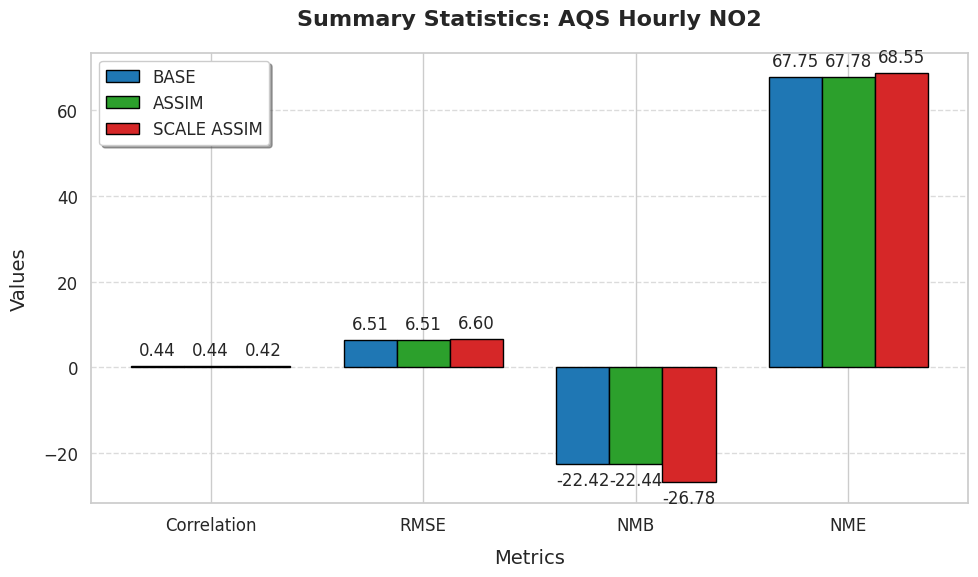

In [7]:
# Enhanced bar chart for metrics
import seaborn as sns

# Use a publication-friendly style
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.size": 14,  # Increase font size
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (12, 8)  # Larger figure size
})

metrics = ['Correlation', 'RMSE', 'NMB', 'NME']
base_values = overall_base_stats.values
assim_values = overall_assim_stats.values
scale_values = overall_scale_stats.values

x = np.arange(len(metrics))  # Label locations
width = 0.25  # Adjusted bar width for better spacing

fig, ax = plt.subplots(figsize=(10, 6))

# Use more distinct colors for better contrast
bars1 = ax.bar(x - width, base_values, width, label='BASE', color='#1f77b4', edgecolor='black')
bars2 = ax.bar(x, assim_values, width, label='ASSIM', color='#2ca02c', edgecolor='black')
bars3 = ax.bar(x + width, scale_values, width, label='SCALE ASSIM', color='#d62728', edgecolor='black')

# Add labels, title, and legend
ax.set_xlabel('Metrics', labelpad=10)
ax.set_ylabel('Values', labelpad=10)
ax.set_title('Summary Statistics: AQS Hourly NO2', pad=20, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='best', frameon=True, shadow=True, fancybox=True)

# Annotate bar values
for bars in [bars1, bars2, bars3]:
    ax.bar_label(bars, fmt='%.2f', padding=5, fontsize=12)

# Add gridlines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure as a high-resolution image for publication
plt.savefig('NO2_Metrics_Comparison.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [8]:
# Initialize lists to store monthly statistics
monthly_stats_base = []
monthly_stats_assim = []
monthly_stats_scale = []

# Loop through each month's files
for base_file, assim_file, scale_file in zip(base_files, assim_files, scale_files):
    # Check if files exist and are not empty
    for file in [base_file, assim_file, scale_file]:
        if not Path(file).is_file() or Path(file).stat().st_size == 0:
            print(f"Error: {file} does not exist or is empty.")
            continue

    # Read the data
    bdf = pd.read_csv(base_file, skiprows=5, na_values=[-999])
    adf = pd.read_csv(assim_file, skiprows=5, na_values=[-999])
    cdf = pd.read_csv(scale_file, skiprows=5, na_values=[-999])

    # Filter to 13th hour (13:00–13:59)
    bdf = bdf[bdf['Shh'] == 14]
    adf = adf[adf['Shh'] == 14]
    cdf = cdf[cdf['Shh'] == 14]

    # Check for required columns
    required_columns = ['NO2_ob', 'NO2_mod']
    if not all(col in bdf.columns for col in required_columns):
        print(f"Error: Missing required columns in {base_file}")
        continue
    if not all(col in adf.columns for col in required_columns):
        print(f"Error: Missing required columns in {assim_file}")
        continue
    if not all(col in cdf.columns for col in required_columns):
        print(f"Error: Missing required columns in {scale_file}")
        continue

    # Rename 'NO2_mod' column in cdf to 'NO2_mod_scale' for clarity
    cdf = cdf.rename(columns={'NO2_mod': 'NO2_mod_scale'})

    # Reset indices to ensure alignment
    bdf = bdf.reset_index()
    adf = adf.reset_index()
    cdf = cdf.reset_index()

    # Join dataframes on index (assumes same order after filtering)
    valid_data = bdf[['NO2_ob', 'NO2_mod']].join(adf[['NO2_mod']], lsuffix='_base', rsuffix='_assim').dropna()
    valid_data = valid_data.join(cdf[['NO2_mod_scale']]).dropna()

    # Group by site (if you want site-level means, otherwise skip this)
    # valid_data = valid_data.groupby('Site_Code').mean().reset_index()

    # Debug: Print intermediate data
    print(valid_data.head())

    # Observed and modeled NO2 for BASE, ASSIM, SCALE_ASSIM
    obs_no2 = valid_data['NO2_ob']
    base_no2 = valid_data['NO2_mod_base']
    assim_no2 = valid_data['NO2_mod_assim']
    scale_no2 = valid_data['NO2_mod_scale']

    # Calculate metrics for BASE, ASSIM, SCALE_ASSIM
    base_metrics = calculate_metrics(obs_no2, base_no2)
    assim_metrics = calculate_metrics(obs_no2, assim_no2)
    scale_metrics = calculate_metrics(obs_no2, scale_no2)

    # Append to the monthly statistics lists
    monthly_stats_base.append(base_metrics)
    monthly_stats_assim.append(assim_metrics)
    monthly_stats_scale.append(scale_metrics)

     NO2_ob  NO2_mod_base  NO2_mod_assim  NO2_mod_scale
262     3.5       1.33030        1.31700        1.29810
263     2.2       0.83070        0.82428        0.80650
264     1.0       0.81705        0.80665        0.46603
265     0.9       1.38460        1.37220        1.02420
266     2.0       1.09200        1.07720        0.56689
     NO2_ob  NO2_mod_base  NO2_mod_assim  NO2_mod_scale
271     2.4        1.0366         1.0408         1.0356
272     3.5        1.0180         1.0249         1.3658
273     2.2        1.1330         1.1448         1.1455
274     1.2        1.1916         1.1910         1.0947
275     7.0        8.3212         8.3098         8.3198
     NO2_ob  NO2_mod_base  NO2_mod_assim  NO2_mod_scale
266     1.6       2.53580         2.5372        2.11890
267     1.5       3.28710         3.2819        2.55840
268     0.8       0.75225         0.7475        0.76829
269     1.1       1.07940         1.0713        0.62073
270     4.5       1.30520         1.3063        

In [9]:
# Convert lists to DataFrames for easier averaging
monthly_stats_base_df = pd.DataFrame(monthly_stats_base, columns=['Correlation', 'RMSE', 'NMB', 'NME'])
monthly_stats_assim_df = pd.DataFrame(monthly_stats_assim, columns=['Correlation', 'RMSE', 'NMB', 'NME'])
monthly_stats_scale_df = pd.DataFrame(monthly_stats_scale, columns=['Correlation', 'RMSE', 'NMB', 'NME'])

# Calculate overall averages
overall_base_stats = monthly_stats_base_df.mean()
overall_assim_stats = monthly_stats_assim_df.mean()
overall_scale_stats = monthly_stats_scale_df.mean()

# Print overall statistics
print("Overall BASE Metrics:")
print(overall_base_stats)
print("\nOverall ASSIM Metrics:")
print(overall_assim_stats)
print("\nOverall SCALE ASSIM Metrics:")
print(overall_scale_stats)

Overall BASE Metrics:
Correlation     0.343243
RMSE            4.970084
NMB           -65.858945
NME            75.366304
dtype: float64

Overall ASSIM Metrics:
Correlation     0.343143
RMSE            4.972837
NMB           -66.003971
NME            75.431193
dtype: float64

Overall SCALE ASSIM Metrics:
Correlation     0.338996
RMSE            5.015917
NMB           -68.011402
NME            76.603664
dtype: float64


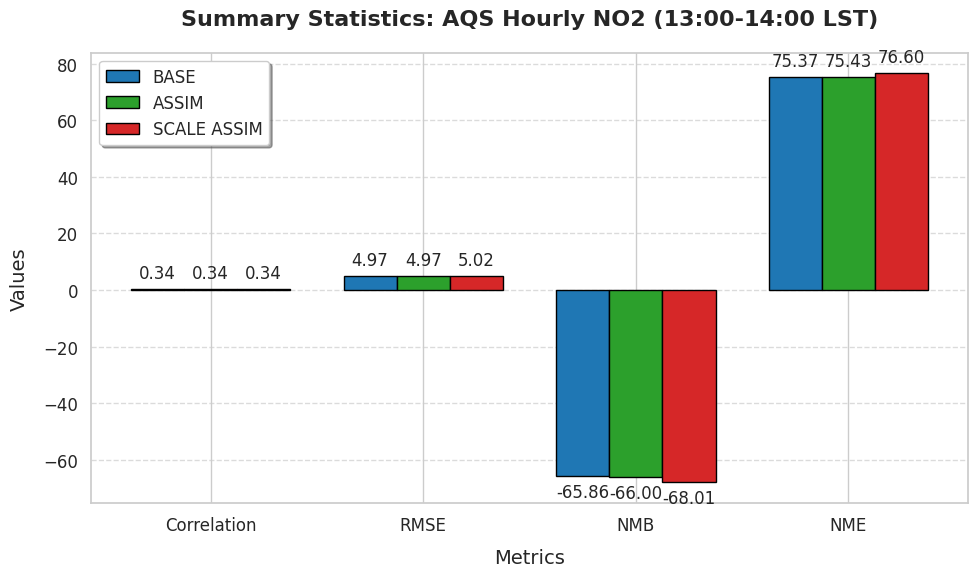

In [10]:
# Enhanced bar chart for metrics
import seaborn as sns

# Use a publication-friendly style
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.size": 14,  # Increase font size
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (12, 8)  # Larger figure size
})

metrics = ['Correlation', 'RMSE', 'NMB', 'NME']
base_values = overall_base_stats.values
assim_values = overall_assim_stats.values
scale_values = overall_scale_stats.values

x = np.arange(len(metrics))  # Label locations
width = 0.25  # Adjusted bar width for better spacing

fig, ax = plt.subplots(figsize=(10, 6))

# Use more distinct colors for better contrast
bars1 = ax.bar(x - width, base_values, width, label='BASE', color='#1f77b4', edgecolor='black')
bars2 = ax.bar(x, assim_values, width, label='ASSIM', color='#2ca02c', edgecolor='black')
bars3 = ax.bar(x + width, scale_values, width, label='SCALE ASSIM', color='#d62728', edgecolor='black')

# Add labels, title, and legend
ax.set_xlabel('Metrics', labelpad=10)
ax.set_ylabel('Values', labelpad=10)
ax.set_title('Summary Statistics: AQS Hourly NO2 (13:00-14:00 LST)', pad=20, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='best', frameon=True, shadow=True, fancybox=True)

# Annotate bar values
for bars in [bars1, bars2, bars3]:
    ax.bar_label(bars, fmt='%.2f', padding=5, fontsize=12)

# Add gridlines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure as a high-resolution image for publication
plt.savefig('NO2_Metrics_Comparison.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [11]:
# ...existing code...

# Define the target hour (e.g., 13 for 13:00-14:00)
TARGET_HOUR = 13

# After reading each CSV:
bdf = pd.read_csv(base_file, skiprows=5, na_values=[-999])
adf = pd.read_csv(assim_file, skiprows=5, na_values=[-999])
cdf = pd.read_csv(scale_file, skiprows=5, na_values=[-999])

# Filter to the target hour (adjust column name if needed)
bdf = bdf[bdf['Hour'] == TARGET_HOUR]
adf = adf[adf['Hour'] == TARGET_HOUR]
cdf = cdf[cdf['Hour'] == TARGET_HOUR]

# ...rest of your code...

KeyError: 'Hour'

In [ ]:
cdf

In [ ]:
# monthly_stats_assim_df

In [ ]:
# monthly_stats_scale_df

In [ ]:
# monthly_stats_base_df

In [12]:
# Initialize lists to store monthly statistics
monthly_stats_base = []
monthly_stats_assim = []
monthly_stats_scale = []

# Loop through each month's files
for base_file, assim_file, scale_file in zip(base_files, assim_files, scale_files):
    # Check if files exist and are not empty
    for file in [base_file, assim_file, scale_file]:
        if not Path(file).is_file() or Path(file).stat().st_size == 0:
            print(f"Error: {file} does not exist or is empty.")
            continue
    
    
    # Read the data
    bdf = pd.read_csv(base_file, skiprows=5, na_values=[-999])
    adf = pd.read_csv(assim_file, skiprows=5, na_values=[-999])
    cdf = pd.read_csv(scale_file, skiprows=5, na_values=[-999])

    
    # Check for required columns
    required_columns = ['O3_ob', 'O3_mod']
    if not all(col in bdf.columns for col in required_columns):
        print(f"Error: Missing required columns in {base_file}")
        continue
    if not all(col in adf.columns for col in required_columns):
        print(f"Error: Missing required columns in {assim_file}")
        continue
    if not all(col in cdf.columns for col in required_columns):
        print(f"Error: Missing required columns in {scale_file}")
        continue
   

    # Rename 'O3_mod' column in cdf to 'O3_mod_scale' for clarity
    cdf = cdf.rename(columns={'O3_mod': 'O3_mod_scale'})

    # Reset indices to ensure alignment
    bdf = bdf.reset_index()
    adf = adf.reset_index()
    cdf = cdf.reset_index()

    # cdf = cdf.rename(columns={'O3_mod': 'O3_mod_scale'})

    # Drop rows with NaN values in the relevant columns
    valid_data = bdf[['O3_ob', 'O3_mod']].join(adf[['O3_mod']], lsuffix='_base', rsuffix='_assim').dropna()

    valid_data = valid_data.join(cdf[['O3_mod_scale']]).dropna()

    # Debug: Print intermediate data
    print(valid_data.head())

    # Observed and modeled O3 for BASE and ASSIM
    obs_O3 = valid_data['O3_ob']
    base_O3 = valid_data['O3_mod_base']
    assim_O3 = valid_data['O3_mod_assim']
    scale_O3 = valid_data['O3_mod_scale']
    
    # Calculate metrics for BASE and ASSIM
    base_metrics = calculate_metrics(obs_O3, base_O3)
    assim_metrics = calculate_metrics(obs_O3, assim_O3)
    scale_metrics = calculate_metrics(obs_O3, scale_O3)
    # Append to the monthly statistics lists
    monthly_stats_base.append(base_metrics)
    monthly_stats_assim.append(assim_metrics)
    monthly_stats_scale.append(scale_metrics)


   O3_ob  O3_mod_base  O3_mod_assim  O3_mod_scale
0   57.0       61.079        60.606        55.864
1   51.0       58.617        58.118        53.667
2   43.0       56.986        56.463        52.212
3   43.0       55.648        55.118        51.056
4   35.0       54.838        54.303        50.460
   O3_ob  O3_mod_base  O3_mod_assim  O3_mod_scale
0   48.0       46.818        46.962        47.039
1   44.0       43.766        43.915        44.229
2   40.0       41.819        41.971        42.492
3   32.0       39.687        39.837        40.574
4   38.0       37.607        37.753        38.644
   O3_ob  O3_mod_base  O3_mod_assim  O3_mod_scale
0   53.0       51.270        52.076        51.331
1   45.0       50.653        51.517        50.653
2   43.0       50.697        51.562        50.638
3   40.0       50.591        51.452        50.520
4   41.0       50.212        51.066        50.141
   O3_ob  O3_mod_base  O3_mod_assim  O3_mod_scale
0   54.0       57.216        56.689        55.221


In [13]:
# Convert lists to DataFrames for easier averaging
monthly_stats_base_df = pd.DataFrame(monthly_stats_base, columns=['Correlation', 'RMSE', 'NMB', 'NME'])
monthly_stats_assim_df = pd.DataFrame(monthly_stats_assim, columns=['Correlation', 'RMSE', 'NMB', 'NME'])
monthly_stats_scale_df = pd.DataFrame(monthly_stats_scale, columns=['Correlation', 'RMSE', 'NMB', 'NME'])

# Calculate overall averages
overall_base_stats = monthly_stats_base_df.mean()
overall_assim_stats = monthly_stats_assim_df.mean()
overall_scale_stats = monthly_stats_scale_df.mean()

# Print overall statistics
print("Overall BASE Metrics:")
print(overall_base_stats)
print("\nOverall ASSIM Metrics:")
print(overall_assim_stats)
print("\nOverall SCALE ASSIM Metrics:")
print(overall_scale_stats)


Overall BASE Metrics:
Correlation     0.705893
RMSE           12.095811
NMB             4.224040
NME            27.198439
dtype: float64

Overall ASSIM Metrics:
Correlation     0.707728
RMSE           12.069486
NMB             4.672249
NME            27.173121
dtype: float64

Overall SCALE ASSIM Metrics:
Correlation     0.707297
RMSE           11.969070
NMB             3.838265
NME            26.842119
dtype: float64


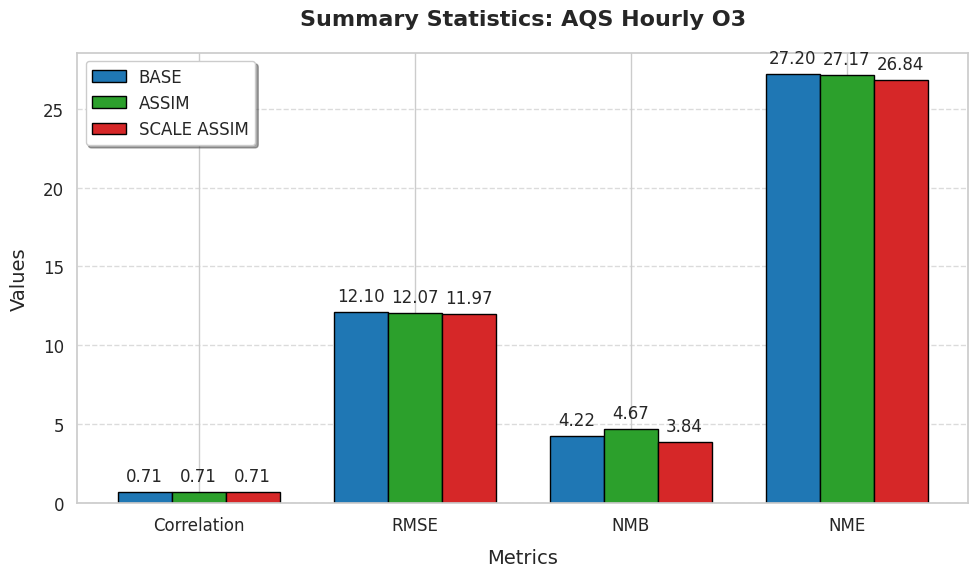

In [14]:
# Enhanced bar chart for metrics
import seaborn as sns

# Use a publication-friendly style
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.size": 14,  # Increase font size
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (12, 8)  # Larger figure size
})

metrics = ['Correlation', 'RMSE', 'NMB', 'NME']
base_values = overall_base_stats.values
assim_values = overall_assim_stats.values
scale_values = overall_scale_stats.values

x = np.arange(len(metrics))  # Label locations
width = 0.25  # Adjusted bar width for better spacing

fig, ax = plt.subplots(figsize=(10, 6))

# Use more distinct colors for better contrast
bars1 = ax.bar(x - width, base_values, width, label='BASE', color='#1f77b4', edgecolor='black')
bars2 = ax.bar(x, assim_values, width, label='ASSIM', color='#2ca02c', edgecolor='black')
bars3 = ax.bar(x + width, scale_values, width, label='SCALE ASSIM', color='#d62728', edgecolor='black')

# Add labels, title, and legend
ax.set_xlabel('Metrics', labelpad=10)
ax.set_ylabel('Values', labelpad=10)
ax.set_title('Summary Statistics: AQS Hourly O3', pad=20, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='best', frameon=True, shadow=True, fancybox=True)

# Annotate bar values
for bars in [bars1, bars2, bars3]:
    ax.bar_label(bars, fmt='%.2f', padding=5, fontsize=12)

# Add gridlines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure as a high-resolution image for publication
plt.savefig('O3_Metrics_Comparison.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [15]:
monthly_stats_base_df

,Correlation,RMSE,NMB,NME
0,0.710514,12.112421,10.669609,31.108461
1,0.697862,11.242444,1.496749,22.655903
2,0.712176,12.533674,0.281072,25.372441
3,0.704739,12.574799,2.211233,28.112512
4,0.704174,12.015715,6.461539,28.742876


In [16]:
monthly_stats_scale_df

,Correlation,RMSE,NMB,NME
0,0.708942,12.126539,11.157972,31.164294
1,0.698420,11.309616,2.524938,22.771987
2,0.711429,12.431158,-0.445166,25.179593
3,0.705376,12.347512,0.656030,27.472178
4,0.712316,11.630523,5.297551,27.622546


In [17]:
monthly_stats_assim_df

,Correlation,RMSE,NMB,NME
0,0.709715,12.161500,11.189914,31.322354
1,0.699022,11.267149,2.422287,22.751200
2,0.714259,12.483988,0.754387,25.305159
3,0.706935,12.511188,2.276065,27.963077
4,0.708709,11.923604,6.718590,28.523815
